**Mô hình dự đoán Open, High, Low, Close cost từ 9h15 đến 10h ngày hôm sau kể từ thời gian thực ( mỗi phút dự đoán 1 tập giá trị gồm Open, High, Low, Close cost ) và phác sự giao động trên biểu đồ ( mô hình chỉ dự đoán dữ liệu cổ phiếu FPT, các cổ phiếu sau train tương tự )**

# Import

In [ ]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor

import gdown
import torch
import torch.nn as nn

# Download and load dataset

In [ ]:
!gdown 1shNJEJLIxItWVQ5tk1kLRtG2DenXDi6n

Downloading...
From: https://drive.google.com/uc?id=1shNJEJLIxItWVQ5tk1kLRtG2DenXDi6n
To: /content/FPT.zip
100% 613k/613k [00:00<00:00, 137MB/s]


In [ ]:
!unzip /content/FPT.zip

Archive:  /content/FPT.zip
  inflating: FPT.csv                 


In [ ]:
df = pd.read_csv('/content/FPT.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


# Utils

In [ ]:
class CsvDataLoader:
  def __init__(self, file_path, train_size, val_size, input_size,
               label_size, offset, batch_size):
    if offset < label_size:
      print(f"Offset will be change from {offset} to {label_size}")
      offset = label_size


    self.file_path = file_path
    self.train_size = train_size
    self.val_size = val_size
    self.input_size = input_size
    self.label_size = label_size
    self.offset = offset
    self.batch_size = batch_size

    #load data

    self.df = pd.read_csv(self.file_path)
    self.df.drop(columns = ["Ticker", "Date/Time", "Volume", "Open Interest"], inplace = True)

    self.X_train, self.Y_train = self.__create_dataset(0, int(train_size*len(self.df)))
    self.X_val, self.Y_val = self.__create_dataset(int(train_size*len(self.df)), int((train_size+val_size))*len(self.df))
    self.X_test, self.Y_test = self.__create_dataset(int((train_size+val_size))*len(self.df), len(self.df))

    #load dataloader
    self.train_loader = self.__create_dataloader(self.X_train, self.Y_train)
    self.val_loader = self.__create_dataloader(self.X_val, self.Y_val)
    self.test_loader = self.__create_dataloader(self.X_test, self.Y_test)
  def __create_dataset(self, beg_idx, end_idx):
    if end_idx is None:
      end_idx = len(self.df) - self.offset - self.label_size

    features, labels = [], []
    beg_idx += self.offset + self.input_size
    for idx in range(beg_idx, end_idx):
      features_beg = idx - self.offset - self.input_size
      features_end = features_beg + self.input_size

      labels_beg = idx - self.offset
      labels_end = labels_beg + self.label_size

      feature = self.df.iloc[features_beg:features_end].to_numpy()
      label = self.df.iloc[labels_beg:labels_end].to_numpy()

      features.append(feature)
      labels.append(label)

    return features, labels

  def __create_dataloader(self, X, Y):
    X_tensor = torch.tensor(X, dtype = torch.float32)
    Y_tensor = torch.tensor(Y, dtype = torch.float32)

    dataset = TensorDataset(X_tensor, Y_tensor)
    dataloader = DataLoader(dataset, batch_size = self.batch_size)

    return dataloader

In [ ]:
class ModelManager:
  def __init__(self, model, train_loader, val_loader, lr):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.lr = lr
    self.criterion = nn.L1Loss()
    self.optimizer = torch.optim.Adam(model.parameters(), lr = self.lr)

  def train(self, epochs, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    self.save_dir = save_dir
    self.save_path = os.path.join(save_dir, "best.pt")

    for epoch in range(epochs):
      start_time = time.time()
      self.model.train()
      total_train_loss = 0
      for inputs, targets in self.train_loader:
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)

        total_train_loss += loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

      avg_train_loss = total_train_loss/len(self.train_loader)
      # Validate the model
      # val_loss = self.evaluate(loader=self.val_loader)



      print(f'Epoch [{epoch + 1}/{epochs}], '
            f'time: {int(time.time() - start_time)}s, '
            f'loss: {avg_train_loss:.4f}, '
            #f'val_loss: {val_loss:.4f}'
            )

  def predict(self, input_data):
    self.model.eval()
    predictions = []
    if isinstance(input_data, DataLoader):
      with torch.no_grad():
        for input, _ in input_data:
          outputs = self.model(input)
          predictions.append(outputs)
    else:
      with torch.no_grad():
        predictions.append(self.model(input))

    return predictions
  def save_model(self):
    torch.save(self.model.state_dict(), self.save_path)
    print("Model saved")
  def load_model(self):
    self.model.load_state_dict(torch.load(self.save_path))
    print("Model loaded")

# Model

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, features):
    super(MLP, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.features = features

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size*features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x.view(-1, self.output_size, self.features)

# Configs

In [ ]:
input_size = 100
label_size = 45
features = 4
offset = 1
train_size = 0.7
val_size = 0.1
epochs = 50
lr = 0.001
batch_size = 64
hidden_size = 64
file_path = '/content/FPT.csv'
weight_dir = 'weights'
save_dir = "./model"
results = []

#Train

In [ ]:
dataloader = CsvDataLoader(file_path, train_size, val_size, input_size,
               label_size, offset, batch_size)

Offset will be change from 1 to 45


<ipython-input-4-cf2f7004e2a3>:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_tensor = torch.tensor(X, dtype = torch.float32)


In [ ]:
model = MLP(input_size*features, hidden_size, label_size, features)
manager = ModelManager(model, dataloader.train_loader, dataloader.val_loader, lr)

In [ ]:
manager.train(epochs, save_dir)

Epoch [1/50], time: 2s, loss: 1.3834, 
Epoch [2/50], time: 2s, loss: 0.8321, 
Epoch [3/50], time: 2s, loss: 0.8259, 
Epoch [4/50], time: 3s, loss: 0.8048, 
Epoch [5/50], time: 2s, loss: 0.7723, 
Epoch [6/50], time: 2s, loss: 0.7572, 
Epoch [7/50], time: 2s, loss: 0.7381, 
Epoch [8/50], time: 3s, loss: 0.7147, 
Epoch [9/50], time: 3s, loss: 0.7041, 
Epoch [10/50], time: 2s, loss: 0.6903, 
Epoch [11/50], time: 2s, loss: 0.6702, 
Epoch [12/50], time: 3s, loss: 0.6558, 
Epoch [13/50], time: 2s, loss: 0.6561, 
Epoch [14/50], time: 2s, loss: 0.6597, 
Epoch [15/50], time: 2s, loss: 0.6626, 
Epoch [16/50], time: 3s, loss: 0.6503, 
Epoch [17/50], time: 3s, loss: 0.6298, 
Epoch [18/50], time: 3s, loss: 0.6019, 
Epoch [19/50], time: 2s, loss: 0.6218, 
Epoch [20/50], time: 3s, loss: 0.5865, 
Epoch [21/50], time: 3s, loss: 0.5827, 
Epoch [22/50], time: 2s, loss: 0.5758, 
Epoch [23/50], time: 2s, loss: 0.5696, 
Epoch [24/50], time: 2s, loss: 0.5617, 
Epoch [25/50], time: 3s, loss: 0.5567, 
Epoch [26

In [ ]:
manager.save_model()

Model saved


In [ ]:
manager.load_model()

Model loaded


# Predict and Visualize

In [ ]:
pred = manager.predict(dataloader.test_loader)

In [ ]:
len(pred[-1][-1])

45

In [ ]:
df_test = pd.DataFrame(data = pred[-1][-1], columns = ["Open",	"High",	"Low",	"Close"])
df_test

,Open,High,Low,Close
0,57.864395,57.352951,57.519421,57.204479
1,57.919029,57.460045,57.524166,57.360291
2,57.751476,57.563828,57.073212,57.097099
3,57.641163,57.117397,57.149075,57.395782
4,57.558464,57.479992,57.531067,57.453842
5,57.414295,57.842854,56.824493,57.094753
6,57.050262,57.169598,57.719196,57.690685
7,57.800770,57.765430,57.589081,57.562710
8,57.558434,57.810848,57.678474,57.707668
9,57.606213,57.820827,57.316093,57.611629


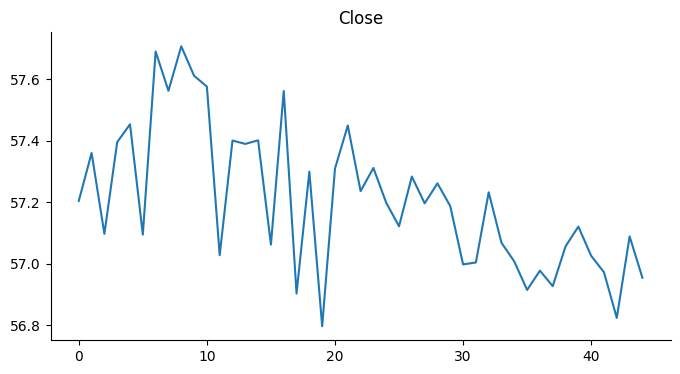

In [ ]:
# @title Close

from matplotlib import pyplot as plt
df_test['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

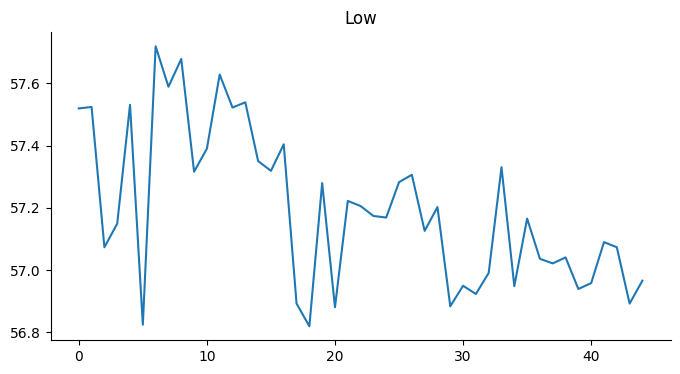

In [ ]:
# @title Low

from matplotlib import pyplot as plt
df_test['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

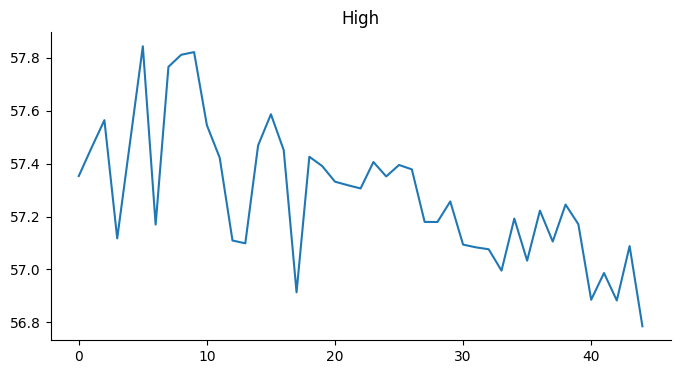

In [ ]:
# @title High

from matplotlib import pyplot as plt
df_test['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

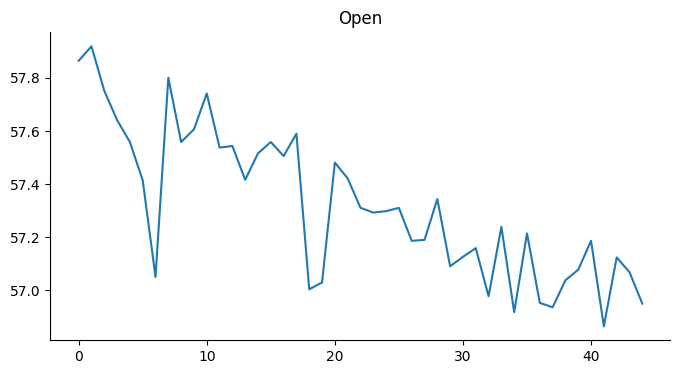

In [ ]:
# @title Open

from matplotlib import pyplot as plt
df_test['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)